<a href="https://colab.research.google.com/github/zemld/TimeseriesHSE/blob/main/algorithms_research/TFT_with_electricity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install u8darts[all]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.7/169.7 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 98.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 354.4/354.4 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 94.3 MB/s eta 0:00:00
  

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.23.5

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 104.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.42.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
xarray 2025.1.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.1 requires n

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from google.colab import drive
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from typing import Tuple

import torch
import torchmetrics
from darts.models import TFTModel
from darts.utils.likelihood_models import QuantileRegression
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.lr_monitor import LearningRateMonitor

from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
drive.mount('/content/drive/')
df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")

Mounted at /content/drive/


<ipython-input-2-b56a3be83c5c>:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/household_power_consumption.txt", sep=";")


In [ ]:
df.head()

,Global_active_power,Global_reactive_power,DateTime
0,4.216,0.418,2006-12-16 17:24:00
1,5.360,0.436,2006-12-16 17:25:00
2,5.374,0.498,2006-12-16 17:26:00
3,5.388,0.502,2006-12-16 17:27:00
4,3.666,0.528,2006-12-16 17:28:00


In [ ]:
# Работаем с данными
# Объединяем Date + Time
df["DateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format="%d/%m/%Y %H:%M:%S")
df = df.drop(columns=["Date", "Time"])

# Приводим столбцы к числовому виду
numeric_columns = [
    "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")

df = df.dropna()

# Группируем данные по часам (было по минутам...)
df = df.resample("h", on="DateTime").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["DateTime"].dt.hour
df["dayofweek"] = df["DateTime"].dt.dayofweek
df["month"] = df["DateTime"].dt.month
df["year"] = df["DateTime"].dt.year
df["day"] = df["DateTime"].dt.day
df["day_of_year"] = df["DateTime"].dt.dayofyear

df = df.dropna()

In [ ]:
df.sample(n = 5)

,DateTime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
1890,2007-03-05 11:00:00,1.366200,0.062800,241.208000,5.616667,0.0,0.250000,17.816667,11,0,3,2007,5,64
31849,2010-08-04 18:00:00,0.307267,0.128533,240.083333,1.400000,0.0,0.500000,1.633333,18,2,8,2010,4,216
30922,2010-06-27 03:00:00,0.363767,0.226667,238.234167,1.763333,0.0,1.166667,1.666667,3,6,6,2010,27,178
11412,2008-04-05 05:00:00,0.266767,0.058300,241.264667,1.090000,0.0,0.000000,0.000000,5,5,4,2008,5,96
30554,2010-06-11 19:00:00,1.751667,0.349400,242.111333,8.323333,19.0,0.000000,1.650000,19,4,6,2010,11,162


In [ ]:
ts_target_probability = TimeSeries.from_dataframe(
    df,
    time_col="DateTime",
    value_cols=["Global_active_power"],
    freq="h",
    fill_missing_dates=True
)

ts_future_covs_probability = TimeSeries.from_dataframe(
    df,
    time_col="DateTime",
    value_cols=["hour", "dayofweek", "month", "day_of_year", ""],
    freq="h"
)

past_covs_cols = ["Global_reactive_power", "Global_intensity", "Voltage"
                  "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

ts_past_covs_probability = TimeSeries.from_dataframe(
    df,
    time_col="DateTime",
    value_cols=past_covs_cols,
    freq="h",
    fill_missing_dates=True
)

In [ ]:
# Нормализуем данные
target_series_scaler_probability = Scaler(scaler=StandardScaler(), global_fit=True)
ts_target_scaled_probability = target_series_scaler_probability.fit_transform(ts_target_probability)

ts_past_scaled_probability = target_series_scaler_probability.fit_transform(ts_past_covs_probability)

In [ ]:
# Устанавливаем временные границы разбиения
train_end = pd.Timestamp(df["DateTime"][int(0.7 * len(df["DateTime"]))])
val_end = pd.Timestamp(df["DateTime"][int(0.85 * len(df["DateTime"]))])

def series_splitter(series):
    train_series = series.drop_after(train_end)
    val_series = series.slice(train_end, val_end)
    test_series = series.drop_before(val_end)

    return train_series, val_series, test_series

In [ ]:
# Разбиваем наш основной ряд
ts_target_train_probability, ts_target_val_probability, ts_target_test_probability = series_splitter(ts_target_scaled_probability)

# Разбиваем другие признаки
ts_future_covs_train_probability, ts_future_covs_val_probability, ts_future_covs_test_probability = series_splitter(ts_future_covs_probability)


ts_past_covs_train_probability, ts_past_covs_val_probability, ts_past_covs_test_probability = series_splitter(ts_past_covs_probability)

In [ ]:
def encode_year(idx):
    return (idx.year - 2006) / (2010 - 2006)

encoders = {
    "cyclic": {"future": ["day", "day_of_year", "dayofweek", "month"]},
    "custom": {"future": [encode_year]},
}

In [ ]:
input_chunk = 48 # Длина окна
output_chunk = 24 # Сколько хотим предсказать

In [ ]:
tft_model_full = TFTModel(
    model_name="electricity_tft_full",

    input_chunk_length=input_chunk,
    output_chunk_length=output_chunk,
    batch_size=64,
    n_epochs=20,
    random_state=42,

    hidden_size=128,
    lstm_layers=2,
    num_attention_heads=2,
    hidden_continuous_size=16,

    likelihood=QuantileRegression([0.1, 0.5, 0.9]),
    torch_metrics=torchmetrics.MeanAbsoluteError(),

    optimizer_cls=torch.optim.Adam,
    optimizer_kwargs={"lr": 1e-3},

    use_static_covariates=True,
    add_encoders=encoders,

    pl_trainer_kwargs={
        "accelerator": "gpu",
        "devices": [0],
        "log_every_n_steps": 10,
        "enable_checkpointing": False,
        "enable_model_summary": True,
        "callbacks": [
            EarlyStopping(monitor="val_loss", patience=10, mode="min"),
        ]
    }
)

In [ ]:
tft_model_full.fit(
    series=ts_target_train_probability,
    past_covariates=ts_past_covs_train_probability,
    future_covariates=ts_future_covs_train_probability,
    val_series=ts_target_val_probability,
    val_past_covariates=ts_past_covs_val_probability,
    val_future_covariates=ts_future_covs_val_probability,
    verbose=True
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params | Mode 
------------------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0      | train
1  | val_metrics                       | MetricCollection                 | 0      | train
2  | input_embeddings                  | _MultiEmbedding                  | 0      | train
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0      | train
4  | encoder_vsn                       | _VariableSelectionNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/module.py:512: You called `self.log('val_MeanAbsoluteError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/core/module.py:512: You called `self.log('train_MeanAbsoluteError', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

TFTModel(output_chunk_shift=0, hidden_size=128, lstm_layers=2, num_attention_heads=2, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=16, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[list[float]] = None), norm_type=LayerNorm, use_static_covariates=True, model_name=electricity_tft_full, input_chunk_length=48, output_chunk_length=24, batch_size=64, n_epochs=20, random_state=42, torch_metrics=MeanAbsoluteError(), optimizer_cls=<class 'torch.optim.adam.Adam'>, optimizer_kwargs={'lr': 0.001}, add_encoders={'cyclic': {'future': ['day', 'day_of_year', 'dayofweek', 'month']}, 'custom': {'future': [<function encode_year at 0x7dbbd911d080>]}}, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'log_every_n_steps': 10, 'enable_checkpointing': False, 'enable_model_summary': True, 'callbacks': [<pytorch_lightning.callbacks.early_stopping.EarlyStopping object at 0x7dbbd8b

In [ ]:
output_chunk = 96

In [ ]:
# Выбираем старт, от конца отступаем input_chunk + output_chunk
predict_start_probability = ts_target_test_probability.time_index[-(input_chunk + output_chunk)]

# Вырезаем подмассив
input_series_probability = ts_target_test_probability.slice(
    start_ts=predict_start_probability,
    end_ts=predict_start_probability + pd.Timedelta(hours=input_chunk - 1)  # input_chunk - 1
)

# Прогнозируем на output_chunk
tft_preds_scaled_probability = tft_model_full.predict(
    n=output_chunk,
    series=input_series_probability,
    past_covariates=ts_past_covs_test_probability,
    future_covariates=ts_future_covs_test_probability,
    verbose=True,
)

# Денормализуем ряды
tft_preds_probability = target_series_scaler_probability.inverse_transform(tft_preds_scaled_probability)

actual_unscaled_probability = target_series_scaler_probability.inverse_transform(ts_target_test_probability[-input_chunk:])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

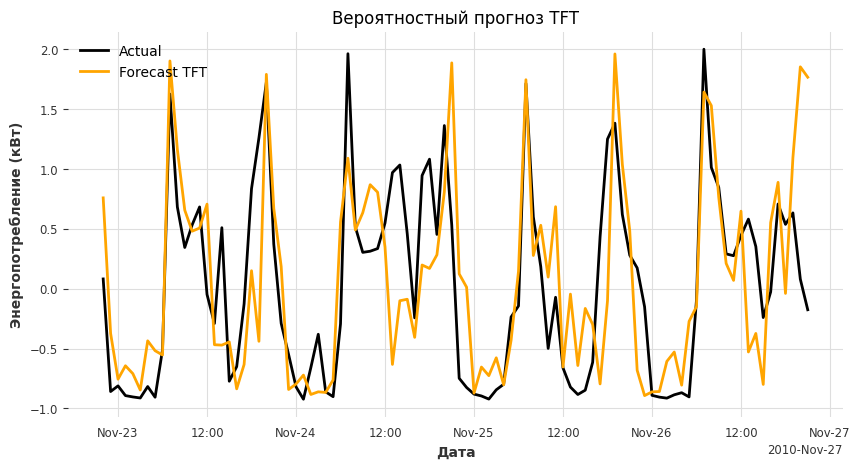

In [ ]:
plt.figure(figsize=(10,5))
ts_target_test_probability[-96:].plot(label="Actual")
tft_preds_scaled_probability.plot(label="Forecast TFT", color='orange')
plt.legend()
plt.title("Вероятностный прогноз TFT")
plt.xlabel('Дата')
plt.ylabel('Энергопотребление (кВт)')
plt.show()